Descargado: /content/data/mes_ensemble_tmax_peru.nc
Descargado: /content/data/prom.tmax.clima.nc
Descargado: /content/data/mes_ensemble_tmin_peru.nc
Descargado: /content/data/prom.tmin.clima.nc
Descargado: /content/data/DEPARTAMENTOS.shp
Descargado: /content/data/DEPARTAMENTOS.dbf
Descargado: /content/data/DEPARTAMENTOS.shx
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Descargado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx
Verificado: /content/data/DEPARTAMENTOS.shp
Verificado: /content/data/DEPARTAMENTOS.dbf
Verificado: /content/data/DEPARTAMENTOS.shx
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shp
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.dbf
Verificado: /content/data/SUDA_NUEVO_SIN_PERU_3.shx


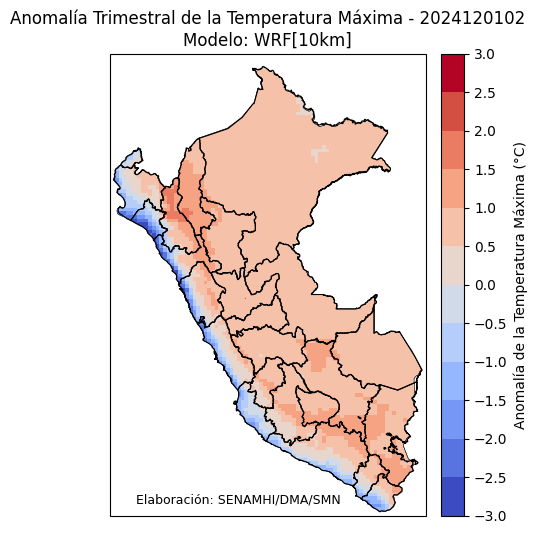

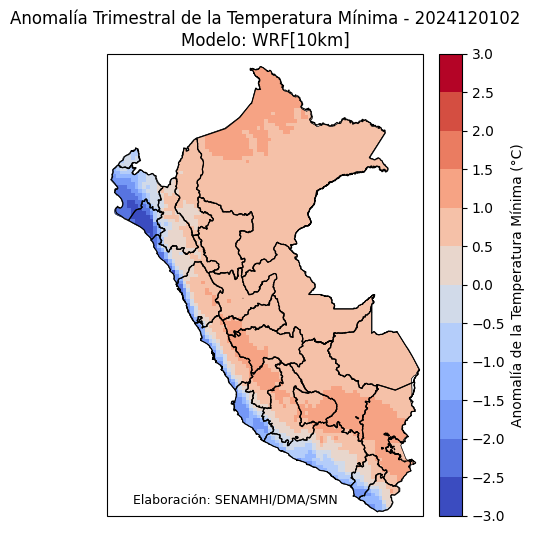

In [6]:
# Importar librerías necesarias
# Instalar librerías necesarias
!pip install geopandas cartopy xarray matplotlib cftime pandas


import os
import requests
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Parámetros base
base_year = 2024
base_month = 11
base_date_str = f"{base_year}{base_month:02d}"

# Función para añadir meses a una fecha
def add_months_to_date(date, months):
    return date + relativedelta(months=months)

# Función para descargar archivos desde una URL
def download_file(url, local_path):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_path, "wb") as f:
            f.write(response.content)
        print(f"Descargado: {local_path}")
    else:
        print(f"Error al descargar {url}: {response.status_code}")
    return local_path

# Ruta base para los datos NetCDF y shapefiles
base_data_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/data"
base_shape_url = "https://raw.githubusercontent.com/Jorgellamocca/GitC3Swrf/main/shape"
local_dir = "/content/data"
os.makedirs(local_dir, exist_ok=True)

# Archivos a descargar
files = {
    # Archivos NetCDF
    "mes_ensemble_tmax_peru": f"{base_data_url}/mes_ensemble_tmax_peru.nc",
    "prom_tmax_clima": f"{base_data_url}/prom.tmax.clima.nc",
    "mes_ensemble_tmin_peru": f"{base_data_url}/mes_ensemble_tmin_peru.nc",
    "prom_tmin_clima": f"{base_data_url}/prom.tmin.clima.nc",
    # Shapefiles
    "peru_shp": f"{base_shape_url}/DEPARTAMENTOS.shp",
    "peru_dbf": f"{base_shape_url}/DEPARTAMENTOS.dbf",
    "peru_shx": f"{base_shape_url}/DEPARTAMENTOS.shx",
    "sudamerica_shp": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.shp",
    "sudamerica_dbf": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.dbf",
    "sudamerica_shx": f"{base_shape_url}/SUDA_NUEVO_SIN_PERU_3.shx"
}

# Descargar archivos
local_files = {}
for name, url in files.items():
    local_path = os.path.join(local_dir, os.path.basename(url))
    local_files[name] = download_file(url, local_path)

# Verificar que los shapefiles están completos
def verify_shapefile(base_name):
    for ext in ['.shp', '.dbf', '.shx']:
        file_path = base_name + ext
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Archivo necesario no encontrado: {file_path}")
        print(f"Verificado: {file_path}")

verify_shapefile(os.path.join(local_dir, "DEPARTAMENTOS"))
verify_shapefile(os.path.join(local_dir, "SUDA_NUEVO_SIN_PERU_3"))

# Rutas locales de los shapefiles
ruta_shapefile_peru = local_files["peru_shp"]
ruta_shapefile_sudamerica = local_files["sudamerica_shp"]

# Cargar shapefiles
peru = gpd.read_file(ruta_shapefile_peru)
sudamerica = gpd.read_file(ruta_shapefile_sudamerica)

# Función para graficar anomalía trimestral
def plot_anomaly_trimestral(archivo_pronostico, archivo_climatologia, variable, output_name, name_title):
    # Abrir los archivos NetCDF
    ds_pronostico = xr.open_dataset(archivo_pronostico, decode_times=False)
    ds_climatologia = xr.open_dataset(archivo_climatologia, decode_times=False)

    # Extraer la fecha base desde los atributos de tiempo
    time_units = ds_pronostico['time'].attrs['units']
    fecha_base_str = time_units.split('since')[-1].strip()
    fecha_base = datetime.strptime(fecha_base_str, "%Y-%m-%d %H:%M:%S")

    # Calcular las fechas reales de los tres primeros tiempos
    meses_desde_base = ds_pronostico['time'].isel(time=slice(0, 3)).values
    fechas_reales = [add_months_to_date(fecha_base, int(meses)) for meses in meses_desde_base]

    # Formatear la fecha en el formato YYYYmes1mes2mes3
    fecha_str = f'{fechas_reales[0].year}{fechas_reales[0].month:02d}{fechas_reales[1].month:02d}{fechas_reales[2].month:02d}'

    # Acceder a las variables de temperatura máxima o mínima
    pronostico_var = ds_pronostico[variable]
    climatologia_var = ds_climatologia[variable]

    # Crear colormap y niveles para anomalías
    cmap = plt.get_cmap('coolwarm', 12)
    norm = BoundaryNorm(np.arange(-3, 3.5, 0.5), cmap.N)

    # Calcular el promedio trimestral para los primeros tres meses
    pronostico_var_trimestral = pronostico_var.isel(time=slice(0, 3)).mean(dim='time')
    climatologia_var_trimestral = climatologia_var.isel(time=slice(0, 3)).mean(dim='time')

    # Calcular la anomalía
    anomalia_var_trimestral = pronostico_var_trimestral - climatologia_var_trimestral

    # Crear el gráfico
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    lon_min, lon_max = -81.5, -68.5
    lat_min, lat_max = -18.5, 0.5
    img = anomalia_var_trimestral.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    peru.boundary.plot(ax=ax, edgecolor='black', linewidth=0.8, zorder=3)
    sudamerica.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.4, zorder=1)
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.02, ticks=np.arange(-3, 4, 0.5))
    cbar.set_label(f'Anomalía de la {name_title} (°C)')
    ax.text(0.73, 0.02, 'Elaboración: SENAMHI/DMA/SMN', horizontalalignment='right', verticalalignment='bottom',
            transform=ax.transAxes, fontsize=9, color='black',
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))
    plt.title(f'Anomalía Trimestral de la {name_title} - {fecha_str}\nModelo: WRF[10km]')
    #plt.savefig(f'/content/figuras/pre_smnwrf_{fecha_str}_anom{output_name}_wrf.png', dpi=300, bbox_inches='tight')
    plt.show()

# Graficar Tmax y Tmin
plot_anomaly_trimestral(local_files["mes_ensemble_tmax_peru"], local_files["prom_tmax_clima"], "t", "TempMax", "Temperatura Máxima")
plot_anomaly_trimestral(local_files["mes_ensemble_tmin_peru"], local_files["prom_tmin_clima"], "t", "TempMin", "Temperatura Mínima")
